<a href="https://colab.research.google.com/github/carlosmhenao/E-commerce-RFM-Analysis/blob/main/Analisis_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_csv('online_retail.csv', encoding='unicode_escape')

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
print("Original transactions:", df.shape[0])

df = df.dropna(subset=['CustomerID'])

df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

df['TotalSales'] = df['Quantity'] * df['UnitPrice']

print("Transactions ready for analysis:", df.shape[0])

df.head()


Original transactions: 397884
Transactions ready for analysis: 397884


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:
import datetime as dt

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalSales': 'sum'
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSales': 'Monetary'
}, inplace=True)

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [ ]:
r_labels = range(5, 0, -1)

f_labels = range(1, 6)
m_labels = range(1, 6)

rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=r_labels)

rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=f_labels)

rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels=m_labels)

rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7
12347.0,2,7,4310.00,5,5,5,555,15
12348.0,75,4,1797.24,2,4,4,244,10
12349.0,19,1,1757.55,4,1,4,414,9
12350.0,310,1,334.40,1,1,2,112,4


In [ ]:
def segment_customer(df):
    if df['RFM_Score'] >= 14:
        return 'Champions'
    elif df['RFM_Score'] >= 11:
        return 'Loyal Customers'
    elif df['RFM_Score'] >= 8:
        return 'Potential Loyalists'
    elif df['RFM_Score'] >= 6:
        return 'Needs Attention'
    elif df['RFM_Score'] >= 4:
        return 'At Risk'
    else:
        return 'Hibernating / Lost'

rfm['Customer_Profile'] = rfm.apply(segment_customer, axis=1)

segment_analysis = rfm.groupby('Customer_Profile').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

segment_analysis.columns = ['Avg_Recency_Days', 'Avg_Frequency', 'Avg_Monetary_Value', 'Total_Customers']
segment_analysis = segment_analysis.sort_values(by='Total_Customers', ascending=False)

segment_analysis


,Avg_Recency_Days,Avg_Frequency,Avg_Monetary_Value,Total_Customers
Customer_Profile,,,,
Potential Loyalists,71.2,2.5,922.8,1055
Loyal Customers,33.4,5.0,2151.3,953
Needs Attention,111.4,1.4,537.2,800
At Risk,208.7,1.1,252.8,700
Champions,10.3,14.1,8121.2,647
Hibernating / Lost,287.3,1.0,144.8,183


/tmp/ipython-input-731152859.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


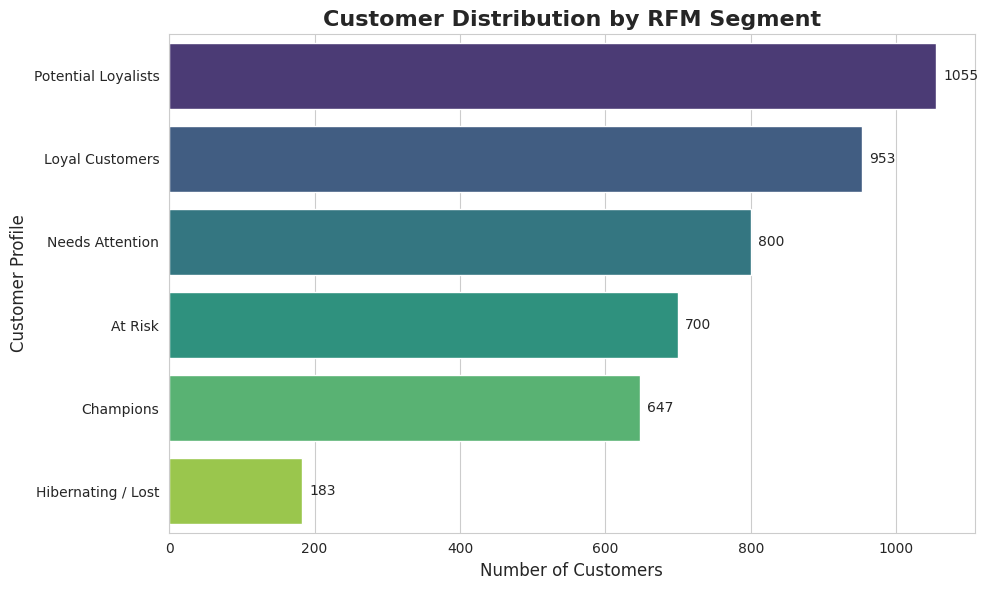

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x='Total_Customers',
    y=segment_analysis.index,
    data=segment_analysis,
    palette='viridis'
)

plt.title('Customer Distribution by RFM Segment', fontsize=16, fontweight='bold')
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('Customer Profile', fontsize=12)

for i in ax.containers:
    ax.bar_label(i, padding=5)

plt.tight_layout()
plt.show()
